In [1]:
import pandas as pd
import numpy as np
 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pymc3 as pm
import patsy

C:\Miniconda3\envs\GLM_with_PyMC3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
nA = 2  #number of levels of A
nB = 3  #number of levels of B

nsample = 10  #number of reps in each

labelsA = ['a{}'.format(i) for i in range(nA)]
labelsB = ['b{}'.format(i) for i in range(nB)]

A = np.repeat(labelsA, repeats=[nsample//nA, nsample//nA + nsample%nA])
B = np.repeat(labelsB, repeats=[nsample//nB, nsample//nB, nsample//nB + nsample%nB])

In [3]:
# cartesian product
import itertools
data = pd.DataFrame([row for row in itertools.product(labelsA, labelsB, np.arange(nsample)+1)], columns=['A', 'B', 'n'])
data.head()

,A,B,n
0,a0,b0,1
1,a0,b0,2
2,a0,b0,3
3,a0,b0,4
4,a0,b0,5


In [4]:
# Whilst the above two are equivalent for simple designs 
# (such as that illustrated), the means parameterization 
# (that does not include an intercept, or overall mean) 
# is limited to simple single factor designs. 
# Designs that involve additional predictors can only be
# accommodated via effects parameterization.

X_design = patsy.dmatrix("1 + A*B", data=data)

X = np.asarray(X_design)
X_design

DesignMatrix with shape (60, 6)
  Intercept  A[T.a1]  B[T.b1]  B[T.b2]  A[T.a1]:B[T.b1]  A[T.a1]:B[T.b2]
          1        0        0        0                0                0
          1        0        0        0                0                0
          1        0        0        0                0                0
          1        0        0        0                0                0
          1        0        0        0                0                0
          1        0        0        0                0                0
          1        0        0        0                0                0
          1        0        0        0                0                0
          1        0        0        0                0                0
          1        0        0        0                0                0
          1        0        1        0                0                0
          1        0        1        0                0                0
          1        

In [5]:
np.random.seed(12345)

eff = np.array([40, 15, 5, 0, -15, 10])
sigma = 3  #residual standard deviation
eps = np.random.normal(loc=0, scale=sigma, size=X.shape[0])

y = np.dot(X, eff) + eps
data['y'] = y
data['A'] = pd.Categorical(data.A, ordered=False)
data['B'] = pd.Categorical(data.B, ordered=False)
data.head()

,A,B,n,y
0,a0,b0,1,39.385877
1,a0,b0,2,41.436830
2,a0,b0,3,38.441684
3,a0,b0,4,38.332809
4,a0,b0,5,45.897342


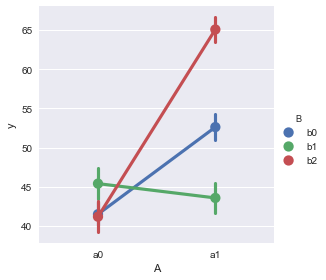

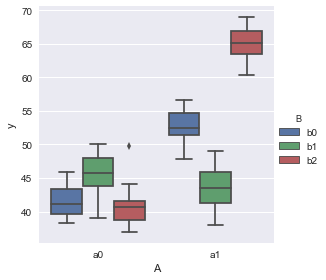

In [6]:
sns.factorplot(x='A', y='y', hue='B', data=data)
sns.factorplot(x='A', y='y', hue='B', kind='box', data=data)

In [7]:
data.groupby(by=('A', 'B')).mean()

n          y
A  B                 
a0 b0  5.5  41.484509
   b1  5.5  45.393358
   b2  5.5  41.164939
a1 b0  5.5  52.614088
   b1  5.5  43.563826
   b2  5.5  65.086505

In [8]:
with pm.Model() as ANOVA_factorial_treatment_coding:
    
    beta = pm.Normal('beta', mu=0, sd=100, shape=(X.shape[1]))
    sd = pm.HalfCauchy('sd', beta=5)
    
    mu = pm.math.dot(X, beta)
    
    # assume same sd. How to index different sd's distributions?
    y_likelihood = pm.Normal('y_likelihood', mu=mu, sd=sd[], observed=data.y)
    
    trace = pm.sample(draws=3000, step=pm.NUTS(), njobs=2, tune=1000)

C:\Miniconda3\envs\GLM_with_PyMC3\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd_log__, beta]


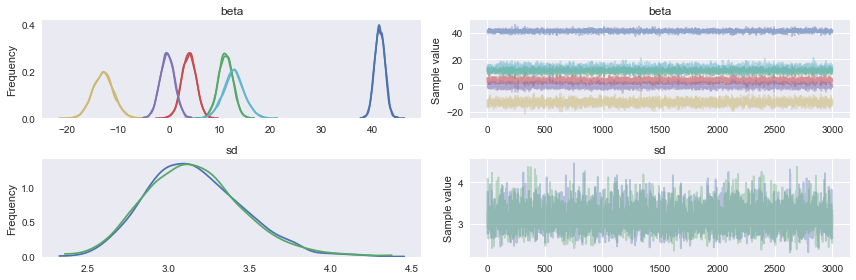

In [9]:
_ = pm.traceplot(trace)

In [10]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta__0,41.493802,0.995530,0.019014,39.565890,43.391974,2184.0,0.999854
beta__1,11.132038,1.431382,0.027785,8.340744,13.953625,2173.0,0.999851
beta__2,3.914762,1.408573,0.025532,1.273505,6.764068,2489.0,0.999834
beta__3,-0.318076,1.410255,0.025050,-3.005772,2.516696,2444.0,0.999864
beta__4,-12.985935,2.021903,0.036788,-16.955086,-9.072226,2461.0,0.999873
beta__5,12.780645,2.025172,0.036429,8.765728,16.730365,2513.0,0.999889
sd,3.158754,0.301864,0.004816,2.623597,3.787724,4163.0,1.000100


In [11]:
df_for_display = pm.summary(trace)

rows_name = X_design.design_info.column_names[:]
rows_name.append('sd')

df_for_display.index = rows_name
df_for_display

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Intercept,41.493802,0.995530,0.019014,39.565890,43.391974,2184.0,0.999854
A[T.a1],11.132038,1.431382,0.027785,8.340744,13.953625,2173.0,0.999851
B[T.b1],3.914762,1.408573,0.025532,1.273505,6.764068,2489.0,0.999834
B[T.b2],-0.318076,1.410255,0.025050,-3.005772,2.516696,2444.0,0.999864
A[T.a1]:B[T.b1],-12.985935,2.021903,0.036788,-16.955086,-9.072226,2461.0,0.999873
A[T.a1]:B[T.b2],12.780645,2.025172,0.036429,8.765728,16.730365,2513.0,0.999889
sd,3.158754,0.301864,0.004816,2.623597,3.787724,4163.0,1.000100


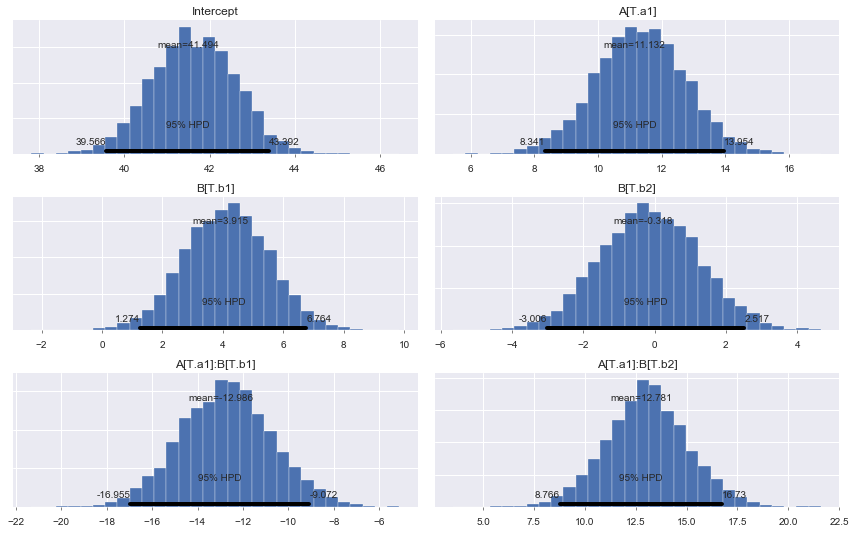

In [12]:
X_design.design_info.column_names
ax = pm.plot_posterior(trace, ['beta'])
for idx, title in enumerate(X_design.design_info.column_names):
    ax[idx].set_title(title)

In [13]:
df_for_contrast = pm.summary(trace)

wch = list(df_for_contrast.index)
wch = [i for i in wch if i.startswith('beta')]
wch

['beta__0', 'beta__1', 'beta__2', 'beta__3', 'beta__4', 'beta__5']

In [14]:
newdata = pd.DataFrame([row for row in itertools.product(labelsA, labelsB)], columns=['A', 'B'])
newdata

,A,B
0,a0,b0
1,a0,b1
2,a0,b2
3,a1,b0
4,a1,b1
5,a1,b2


In [15]:
Xmat = patsy.dmatrix('1 + A * B', data = newdata, return_type='dataframe')
Xmat

,Intercept,A[T.a1],B[T.b1],B[T.b2],A[T.a1]:B[T.b1],A[T.a1]:B[T.b2]
0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,1.0,0.0,0.0
3,1.0,1.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,0.0,1.0,0.0
5,1.0,1.0,0.0,1.0,0.0,1.0


In [16]:
coefs = trace['beta']
coefs.shape

(6000, 6)

In [17]:
fit = np.dot(coefs, Xmat.T)
fit.shape

(6000, 6)

In [18]:
print(np.array_str(fit[:10, :], precision=2, suppress_small=True))

[[41.59 45.68 42.7  53.3  42.14 65.93]
 [39.64 45.5  40.32 53.26 43.72 65.34]
 [40.18 45.73 41.21 53.23 43.66 64.4 ]
 [42.11 45.15 40.24 52.02 43.51 64.9 ]
 [41.8  45.03 40.76 53.51 42.52 64.41]
 [42.21 44.62 40.96 54.89 43.8  65.7 ]
 [40.83 45.41 40.23 55.09 42.72 66.86]
 [40.29 44.69 43.05 50.84 41.78 64.94]
 [41.6  44.73 39.54 53.88 42.44 65.23]
 [42.1  44.25 40.13 54.4  43.82 65.23]]


In [19]:
fit

array([[41.59374893, 45.68144766, 42.69750424, 53.30464086, 42.13566194,
        65.93294152],
       [39.63937145, 45.49819098, 40.32350881, 53.26232256, 43.72275566,
        65.34342477],
       [40.17946895, 45.7296496 , 41.2097796 , 53.2262761 , 43.66128525,
        64.39575595],
       ...,
       [40.00831971, 43.81327174, 40.7773611 , 50.33772959, 42.9268659 ,
        65.67090661],
       [41.21223207, 44.87108115, 40.97373387, 52.37948404, 44.56386636,
        64.49533699],
       [41.95913885, 45.17623286, 40.58590203, 53.2017757 , 43.0924139 ,
        66.37869602]])

In [24]:
pm.hpd(fit[:, 2] - fit[:, 0])

array([-3.00577173,  2.51669586])

In [44]:
np.mean(fit[:, 2] - fit[:, 0])

-0.3180756298209489

In [45]:
np.std(fit[:, 2] - fit[:, 0])

1.4102551456923778

In [52]:
X.shape

(60, 6)

In [55]:
# try different sd
eff = np.array([40, 15, 5, 0, -15, 10])
sigma = 1  #residual standard deviation
eps = np.random.normal(loc=0, scale=sigma, size=X.shape[0])

y = np.dot(X, eff) + eps
data['y'] = y
data['A'] = pd.Categorical(data.A, ordered=False)
data['B'] = pd.Categorical(data.B, ordered=False)
data.head()

,A,B,n,y
0,a0,b0,1,40.353607
1,a0,b0,2,40.702110
2,a0,b0,3,39.725431
3,a0,b0,4,39.860858
4,a0,b0,5,40.107657


In [56]:
with pm.Model() as ANOVA_factorial_treatment_coding_sd:
    
    beta = pm.Normal('beta', mu=0, sd=100, shape=(X.shape[1]))
    sd = pm.HalfCauchy('sd', beta=5, shape=(nA, nB))
    
    mu = pm.math.dot(X, beta)
    
    # assume same sd. How to index different sd's distributions?
    y_likelihood = pm.Normal('y_likelihood', mu=mu, sd=sd[data.A.cat.codes, data.B.cat.codes], observed=data.y)
    
    trace = pm.sample(draws=3000, step=pm.NUTS(), njobs=2, tune=1000)

C:\Miniconda3\envs\GLM_with_PyMC3\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd_log__, beta]


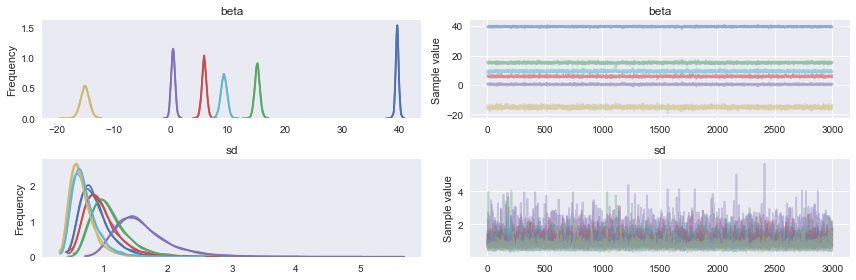

In [57]:
_ = pm.traceplot(trace)